In [5]:
import h5py, glob, tifffile, os
from tqdm import tqdm
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
DATA_DIR = '/media/ubuntu/HD/Data/Audioset-Seg/data_logmel'

In [20]:
data_dirs = glob.glob(f'{DATA_DIR}/*')

metadata = {"id": [], "class": []}

for data_dir in tqdm(data_dirs):
    tiff_files = glob.glob(f'{data_dir}/*.tiff')
    tiff_ids = []
    for tiff_file in tiff_files:
        class_name = tiff_file.split('/')[-2]
        tiff_id = '_'.join(tiff_file.split('/')[-1].split('_')[:-1])
        if tiff_id not in tiff_ids:
            tiff_ids.append(tiff_id)
            metadata['id'].append(tiff_id)
            metadata['class'].append(class_name)
        # print(class_name, tiff_id)
    # break

metadata = pd.DataFrame(metadata)
print(metadata.shape)
metadata.head(5)

100%|██████████| 436/436 [00:41<00:00, 10.49it/s]

(261792, 2)


,id,class
0,9kMTqmnH0h8,Sizzle
1,j95VSxb0kSw,Sizzle
2,MAi4nKCWsh4,Sizzle
3,Qga_GEfMRNc,Sizzle
4,1CPfFe_5hyQ,Sizzle


In [28]:
valid_class = []

for class_name in tqdm(metadata['class'].unique()):
    temp_data = metadata[metadata['class'] == class_name]
    if temp_data.shape[0] < 10: continue
    valid_class.append(class_name)

valid_metadata = metadata[metadata['class'].isin(valid_class)]

print(valid_metadata.shape)
valid_metadata.head(5)

  0%|          | 0/436 [00:00<?, ?it/s]

100%|██████████| 436/436 [00:05<00:00, 73.44it/s]

(261572, 2)


,id,class
0,9kMTqmnH0h8,Sizzle
1,j95VSxb0kSw,Sizzle
2,MAi4nKCWsh4,Sizzle
3,Qga_GEfMRNc,Sizzle
4,1CPfFe_5hyQ,Sizzle


In [29]:
kfold = 10
valid_metadata['fold'] = [x % kfold for x in range(valid_metadata.shape[0])]

print(valid_metadata.shape)
valid_metadata.head(5)

(261572, 3)


/tmp/ipykernel_32216/1232165936.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_metadata['fold'] = [x % kfold for x in range(valid_metadata.shape[0])]


,id,class,fold
0,9kMTqmnH0h8,Sizzle,0
1,j95VSxb0kSw,Sizzle,1
2,MAi4nKCWsh4,Sizzle,2
3,Qga_GEfMRNc,Sizzle,3
4,1CPfFe_5hyQ,Sizzle,4


In [30]:
valid_metadata.to_csv('./metadata/tiff_metadata.csv', index=False)

In [22]:
class_counts = metadata['class'].apply(lambda x: x.value_counts().count())
print(class_counts)

AttributeError: 'str' object has no attribute 'value_counts'

In [3]:
tiff_files = glob.glob(f'{DATA_DIR}/Bark/*')[:512]
len(tiff_files)

512

In [4]:
output_file = "images.h5"  # 输出的H5文件名

with h5py.File(output_file, "w") as h5_file:
    # 创建一个数据集来存储图像数据
    image_dataset = h5_file.create_dataset("logmels", (len(tiff_files), 65, 64), 
                                           dtype=np.float16)
    label_dataset = h5_file.create_dataset("labels", (len(tiff_files), ), 
                                           dtype=np.int32)

    # 遍历图像文件并将它们写入H5文件
    for i, image_file in enumerate(tiff_files):
        image_data = tifffile.imread(image_file)
        h, w = image_data.shape
        image_dataset[i] = image_data.astype(np.float16)
        label_dataset[i] = i

In [8]:
# 打印保存的H5文件信息
with h5py.File(output_file, "r") as h5_file:
    print("H5文件中的数据集名称:", list(h5_file.keys()))
    print(h5_file["logmels"].shape)
    print(h5_file["labels"].shape)

H5文件中的数据集名称: ['labels', 'logmels']
(512, 65, 64)
(512,)


In [4]:
output_file = '/media/ubuntu/HD/Data/Audioset-Seg/data_logmel_hdf5/fold0/data_0_1024.h5'
with h5py.File(output_file, "r") as h5_file:
    print("H5文件中的数据集名称:", list(h5_file.keys()))
    print(len(h5_file))
    print(h5_file["datasets"].shape[0])
    print(h5_file["labels"].shape)
    print(h5_file["labels"][:32])

H5文件中的数据集名称: ['datasets', 'labels']
2
1024
(1024,)
[322 182 135  63 291 192  85 156 154 154 366 341 198 198  85 291 198 291
 322  30 308 198 256  26 135 310 168 154  36  41 182  71]


In [6]:
output_file = '/media/ubuntu/ssd2t/AIGroup/Audio-Data/audioset_strong/logmel/train_data.h5'
data = None
with h5py.File(output_file, "r") as h5_file:
    print("H5文件中的数据集名称:", list(h5_file.keys()))
    print(h5_file["audio_name"].shape)
    print(h5_file["audio_name"][0])
    print(h5_file["logmel"].shape)
    data = h5_file["logmel"][0]
    print(h5_file["target"].shape)
    print(h5_file["target"][0])

H5文件中的数据集名称: ['audio_name', 'logmel', 'target']
(37,)
b'Yb0RFKhbpFJA_0.wav'
(37, 201, 64)
(37,)
[ 52 239 441]


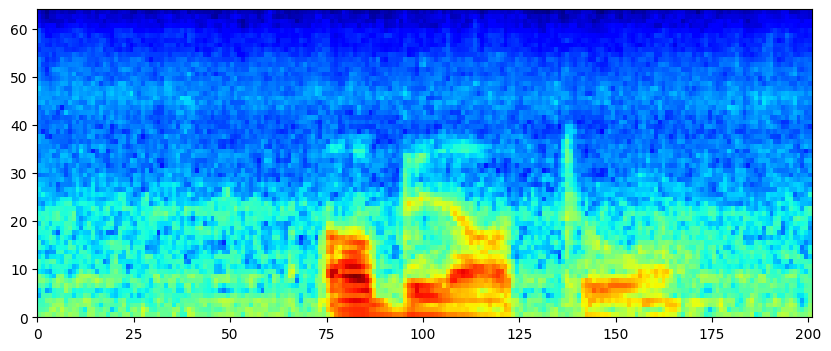

In [8]:
plt.figure(figsize=(10, 4))
plt.imshow(np.flipud(np.transpose(data)), 
    cmap=plt.cm.jet, 
    aspect='auto',
    extent=[0, data.shape[0], 0, data.shape[1]])
plt.show()